In [1]:
import torch
import torchvision

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import PIL

In [5]:
import seaborn as sns

In [6]:
from os import path

In [7]:
train_data = torchvision.datasets.FashionMNIST(
    root=path.join("..", "data"),
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

    # Download test data
test_data = torchvision.datasets.FashionMNIST(
    root=path.join("..", "data"),
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

class is : 9
torch.float32
torch.Size([1, 28, 28])


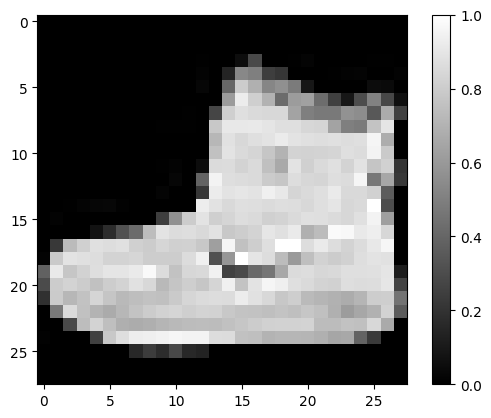

In [8]:
def _():
    image_tensor, cls = train_data[0]
    plt.imshow(image_tensor.squeeze(), cmap="grey")
    plt.colorbar()
    print(f"class is : {cls}")
    print(image_tensor.dtype)
    print(image_tensor.shape)
_()

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
image_to_tensor = torchvision.transforms.PILToTensor()
tensor_to_image = torchvision.transforms.ToPILImage()

In [12]:
image_tensor, cls = train_data[0]
print(f"shape : {image_tensor.shape}")
image = tensor_to_image(image_tensor)
image

shape : torch.Size([1, 28, 28])


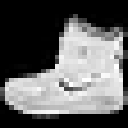

In [13]:
image.resize(size=(128,128,), resample=PIL.Image.NEAREST)

In [14]:
image.mode

'L'

In [15]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28 * 28, 512)
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, 10)

    def forward(self, x):
        x0 = self.flatten(x)
        x1 = F.relu(self.layer1(x0))
        x2 = F.relu(self.layer2(x1))
        x3 = self.layer3(x2)
        return x3

tensor([[ 0.1424, -0.0710, -0.0371,  0.0951, -0.0486,  0.1545, -0.0003,  0.0764,
         -0.0658, -0.0068]], grad_fn=<AddmmBackward0>)
tensor([0.1122, 0.0906, 0.0938, 0.1070, 0.0927, 0.1136, 0.0973, 0.1050, 0.0911,
        0.0966])


<Axes: xlabel='Category', ylabel='Probability'>

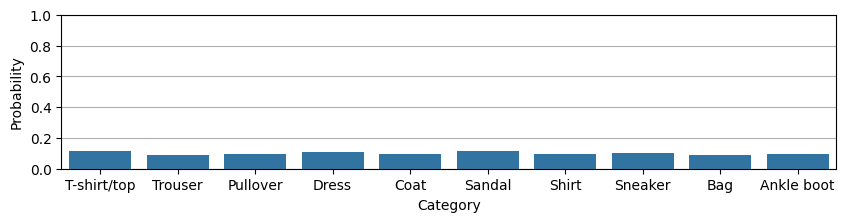

In [16]:
model_cpu = Model()
model_cpu.eval()

logits = model_cpu(train_data[0][0])
print(logits)

probas = torch.nn.functional.softmax(logits, dim=-1).squeeze().detach().clone()
print(probas)

df = pd.DataFrame(
    {
        "Category": train_data.classes,
        "Probability": probas.numpy(),
    }
)

plt.figure(figsize=(10, 2))
plt.ylim(0.0, 1.0)
plt.grid(True)
sns.barplot(x="Category", y="Probability", data=df)

In [17]:
image_tensor.shape

torch.Size([1, 28, 28])

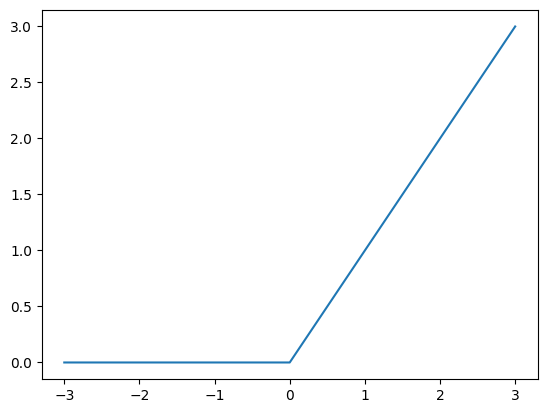

In [18]:
def _():
    relu = torch.nn.ReLU()
    input_1 = torch.linspace(-3.0, 3.0, 7)
    plt.plot(input_1, relu(input_1))
_()

In [19]:
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

It measures the difference between two probability distributions: here a computed probability distribution $p=(p_0, \dots, p_{n-1})$ and the "deterministic" distribution $e_i$ that states that the $i$ event is certain: every entry of $e_i$ is null but the $i$th which is equal to 1:

$$
e_i=(0, \dots, 0, 1, 0, \dots, 0)
$$

The difference is measured with:

$$
\mathrm{loss}(p, e_i) = - \sum_{j} e_{ij} \log p_j = - \log p_i. 
$$

The loss is zero when $p_i = 1$ (perfect match) and $\infty$ when $p_i = 0$. It does not depend on the distribution of the $p_j$ for $j \neq i$.

/// warning

The pytorch cross entropy function works directly with unnormalized log probabilities 

$$
\ell_i := \log p_i + c
$$

(the log probabilities up to a shared constant $c$) instead of the probabilites $p$. 
The deterministic distribution is also specified by the index $i$ instead of the vector $q=e_i$.
Hence, it actually computes

$$
\mathrm{loss}(\ell, i) := -\ell_i  + \log \left( \sum_je^{\ell_j} \right). 
$$

///

In [20]:
loss = loss_fn(
    input = torch.tensor([1.0, 0.0]).log(), 
    target = torch.tensor(1)
)
print(loss)
loss = loss_fn(
    input = torch.tensor([0.0, 1.0]).log(), 
    target = torch.tensor(1)
)
print(loss)

tensor(inf)
tensor(0.)


In [21]:
train_data_device = (train_data.data / 255).to(device)
train_labels_device = train_data.targets.to(device)

test_data_device = (test_data.data / 255).to(device)
test_labels_device = test_data.targets.clone().to(device)

In [22]:
batch_size = 64

In [23]:
class CustomDataSet:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __getitem__(self, key):
        return (self.data[key], self.labels[key],)
    def __len__(self):
        return len(self.data)

ds = CustomDataSet(train_data_device, train_labels_device)
dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)

test_ds = CustomDataSet(test_data_device, test_labels_device)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, [x, y] in enumerate(dataloader):
        pred = model(x)

        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            current = (batch + 1) * len(x)
            loss_item = loss.item()
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

In [33]:
def test(dataloader, model, loss_fn):
        """
        Returns:
          - score, the probability of a correct inference on the test dataset
        """
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        model.eval()
        test_loss, correct = (0, 0)
        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X)
                test_loss = test_loss + loss_fn(pred, y).item()
                correct = correct + (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss = test_loss / num_batches
        correct = correct / size
        print(f'Test Error: \n Accuracy: {100 * correct:>0.2f}%, Avg loss: {test_loss:>8f} \n')
        return correct

In [29]:
def learn(model, loss_fn, max_epoch=10, lr=1e-3, list_score_train=None, list_score_test=None):
    """
    Launch max_epoch train
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    epoch = 0
    while epoch < max_epoch:
        print(f"Epoch {epoch}\n-------------------------------")
        train(dataloader, model, loss_fn, optimizer)
        # score train
        if list_score_train is not None:
            score = test(dataloader, model, loss_fn)
            list_score_train.append(score)
        # score train
        if list_score_test is not None:
            score = test(test_dataloader, model, loss_fn)
            list_score_test.append(score)
        epoch += 1
        
    print("Done!")

In [34]:
list_score_train = []
list_score_test = []

model_device = Model().to(device)

list_score_train.append(test(dataloader, model_device, loss_fn))
list_score_test.append(test(test_dataloader, model_device, loss_fn))

Test Error: 
 Accuracy: 8.58%, Avg loss: 2.305342 

Test Error: 
 Accuracy: 8.64%, Avg loss: 2.305446 



In [35]:
learn(model_device, loss_fn, max_epoch=20, lr=1e-3, list_score_train=list_score_train, list_score_test=list_score_test)

Epoch 0
-------------------------------
loss: 2.303228  [   64/60000]
loss: 2.285612  [ 6464/60000]
loss: 2.276350  [12864/60000]
loss: 2.257454  [19264/60000]
loss: 2.245569  [25664/60000]
loss: 2.234661  [32064/60000]
loss: 2.206423  [38464/60000]
loss: 2.193694  [44864/60000]
loss: 2.161296  [51264/60000]
loss: 2.140994  [57664/60000]
Test Error: 
 Accuracy: 45.62%, Avg loss: 2.148894 

Test Error: 
 Accuracy: 44.37%, Avg loss: 2.149746 

Epoch 1
-------------------------------
loss: 2.142536  [   64/60000]
loss: 2.131123  [ 6464/60000]
loss: 2.090165  [12864/60000]
loss: 2.071676  [19264/60000]
loss: 2.042579  [25664/60000]
loss: 2.030457  [32064/60000]
loss: 1.982662  [38464/60000]
loss: 1.900591  [44864/60000]
loss: 1.927330  [51264/60000]
loss: 1.902645  [57664/60000]
Test Error: 
 Accuracy: 54.87%, Avg loss: 1.870922 

Test Error: 
 Accuracy: 54.46%, Avg loss: 1.872897 

Epoch 2
-------------------------------
loss: 1.924852  [   64/60000]
loss: 1.830720  [ 6464/60000]
loss: 1.

In [36]:
torch.save(model_device.state_dict(), path.join("..", "models", "model.pth"))

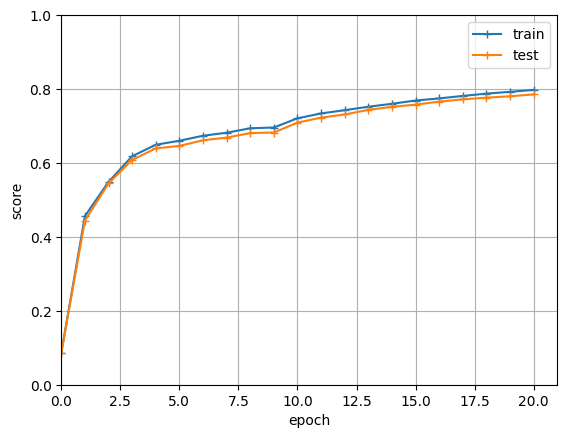

In [37]:
def _():
    plot_x = range(len(list_score_train))
    plt.plot(plot_x, list_score_train, "+-", label="train")
    plt.plot(plot_x, list_score_test, "+-", label="test")
    plt.xlabel("epoch")
    plt.ylabel("score")
    plt.xlim(left=0, right=len(plot_x))
    plt.ylim(0., 1.)
    plt.grid(True)
    plt.legend()
_()

classe : Bag


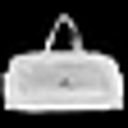

In [38]:
ix = 62
tensor, cls = test_data[ix]
str_cls = test_data.classes[cls]
print(f"classe : {str_cls}")

tensor_to_image(tensor).resize(size=(128, 128))

In [48]:
model_device.eval()
pred = model_device(tensor.to(device)).detach().cpu()
print("affichage des logits")
pred

affichage des logits


tensor([[-5.8063, -8.6506, -1.4485, -2.9480,  1.1748,  5.6150, -1.2851,  2.3484,
          8.2967,  1.9068]])

In [49]:
probas = torch.nn.functional.softmax(pred, dim=-1).squeeze().detach().clone()

df = pd.DataFrame(
    {
        "Category": train_data.classes,
        "Probability": probas.numpy(),
    }
)
df_transpose = df.set_index("Category", drop=True)
df_transpose = df_transpose.transpose()
df_transpose

Category,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Probability,6.986413e-07,4.064618e-08,0.000055,0.000012,0.000752,0.063749,0.000064,0.002431,0.931373,0.001563


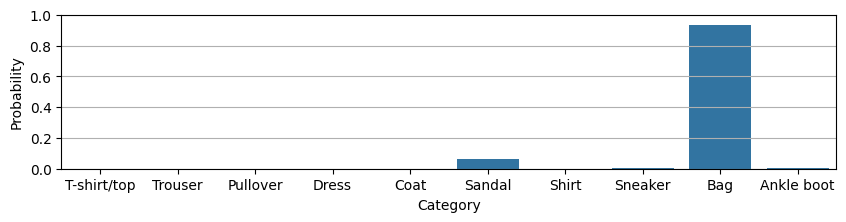

In [50]:
def _():
    plt.figure(figsize=(10, 2))
    plt.ylim(0.0, 1.0)
    plt.grid(True)
    sns.barplot(x="Category", y="Probability", data=df)
_()